In [12]:
import sqlite3
import pandas as pd
from datetime import datetime, timedelta
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

## Data

In [2]:
# Path to your .db file
db_path = r'C:\Users\marco\OneDrive\Desktop\ADV Project\Datasets\y_bsky_feb.db'

conn = sqlite3.connect(db_path)
# Queries
query_created = """
SELECT user_id, thread_id, round
FROM post
WHERE comment_to = -1 AND shared_from = -1
"""

query_replied = """
SELECT user_id, thread_id, comment_to, round
FROM post
WHERE comment_to != -1
"""

query_quoted = """
SELECT user_id, post_id, round
FROM mentions
WHERE answered = 1
"""


In [3]:
# Load results into DataFrames
df_created = pd.read_sql_query(query_created, conn)
df_replied = pd.read_sql_query(query_replied, conn)
df_quoted = pd.read_sql_query(query_quoted, conn)

# Close the connection
conn.close()

In [4]:
# Function for converting round to timedate
def convert_round_to_february_time(round_value):
    """
    Converte 'round' in una data e ora nel mese di Febbraio.
    Ogni 'round' è un'ora, partendo da 0 (01 Febbraio, 00:00).
    """
    start_datetime = datetime.strptime("2023-02-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    return start_datetime + timedelta(hours=round_value)

# Applica la conversione per ogni DataFrame
df_created['timestamp'] = df_created['round'].apply(convert_round_to_february_time)
df_replied['timestamp'] = df_replied['round'].apply(convert_round_to_february_time)
df_quoted['timestamp'] = df_quoted['round'].apply(convert_round_to_february_time)

# Mostra i risultati
print("Created Posts:")
print(df_created)

print("\nReplied Posts:")
print(df_replied)

print("\nQuoted Posts:")
print(df_quoted)

# Salva in CSV (opzionale)
df_created.to_csv("created_posts_with_time_february.csv", index=False)
df_replied.to_csv("replied_posts_with_time_february.csv", index=False)
df_quoted.to_csv("quoted_posts_with_time_february.csv", index=False)

Created Posts:
      user_id  thread_id  round           timestamp
0         145          1      3 2023-02-01 03:00:00
1          26          5      5 2023-02-01 05:00:00
2          11          6      7 2023-02-01 07:00:00
3          80          8      8 2023-02-01 08:00:00
4           2         10      9 2023-02-01 09:00:00
...       ...        ...    ...                 ...
2732      631       8426    720 2023-03-03 00:00:00
2733     1053       8428    720 2023-03-03 00:00:00
2734     1053       8429    720 2023-03-03 00:00:00
2735      720       8430    720 2023-03-03 00:00:00
2736     1168       8431    720 2023-03-03 00:00:00

[2737 rows x 4 columns]

Replied Posts:
      user_id  thread_id  comment_to  round           timestamp
0         101          1           1      3 2023-02-01 03:00:00
1          94          1           1      3 2023-02-01 03:00:00
2          94          1           1      3 2023-02-01 03:00:00
3         176          1           3      8 2023-02-01 08:00:00


In [5]:
# Add a 'type' column to identify the source of each record
df_created['type'] = 'Created'
df_replied['type'] = 'Replied'
df_quoted['type'] = 'Quoted'

# Standardize column names for concatenation
df_created = df_created.rename(columns={"thread_id": "interaction_id"})
df_replied = df_replied.rename(columns={"thread_id": "interaction_id", "comment_to": "extra_info"})
df_quoted = df_quoted.rename(columns={"post_id": "interaction_id"})

# Add missing columns to ensure alignment
df_created['extra_info'] = None
df_quoted['extra_info'] = None

# Concatenate all DataFrames
df_combined = pd.concat([df_created, df_replied, df_quoted], ignore_index=True)

# Display the combined DataFrame
print(df_combined)

# Save to a CSV file (optional)
df_combined.to_csv("combined_interactions.csv", index=False)

       user_id  interaction_id  round           timestamp     type extra_info
0          145               1      3 2023-02-01 03:00:00  Created       None
1           26               5      5 2023-02-01 05:00:00  Created       None
2           11               6      7 2023-02-01 07:00:00  Created       None
3           80               8      8 2023-02-01 08:00:00  Created       None
4            2              10      9 2023-02-01 09:00:00  Created       None
...        ...             ...    ...                 ...      ...        ...
10739     1042            8224    714 2023-03-02 18:00:00   Quoted       None
10740      551            8230    714 2023-03-02 18:00:00   Quoted       None
10741     1136            8256    715 2023-03-02 19:00:00   Quoted       None
10742     1136            8283    716 2023-03-02 20:00:00   Quoted       None
10743      261            8346    717 2023-03-02 21:00:00   Quoted       None

[10744 rows x 6 columns]


## Bipartite Graph Creation

In [8]:
import networkx as nx
import pandas as pd

# Create the bipartite graph
B = nx.Graph()

# Add nodes and edges for the bipartite graph
for _, row in df_combined.iterrows():
    # Add user node
    user_id = f"user_{row['user_id']}"
    B.add_node(user_id, bipartite='user')  # Mark as 'user' type in the bipartite graph

    # Add post node
    post_id = f"post_{row['interaction_id']}"
    B.add_node(post_id, bipartite='post')  # Mark as 'post' type in the bipartite graph

    # Extract date (month and day) from the 'timestamp' column
    interaction_date = row['timestamp'].strftime('%m-%d')

    # Add edge between user and post with interaction details
    B.add_edge(
        user_id, 
        post_id, 
        interaction=row['type'].lower(),  # 'created', 'replied', 'quoted'
        date=interaction_date
    )

# Optional: Check the bipartite graph
print(f"Number of nodes: {len(B.nodes())}")
print(f"Number of edges: {len(B.edges())}")


Number of nodes: 5644
Number of edges: 9202


In [9]:
# Show the number of nodes and edges in the graph
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")

# Display the first 10 edges with their interaction type
print("Example of edges in the bipartite graph with interaction type:")
for u, v, data in list(B.edges(data=True))[:10]:  # show only the first 10
    print(f"{u} -> {v} (interaction: {data['interaction']})")


Number of nodes: 5644
Number of edges: 9202
Example of edges in the bipartite graph with interaction type:
user_145 -> post_1 (interaction: created)
user_145 -> post_278 (interaction: replied)
user_145 -> post_234 (interaction: replied)
user_145 -> post_25 (interaction: replied)
user_145 -> post_729 (interaction: replied)
user_145 -> post_739 (interaction: replied)
user_145 -> post_6223 (interaction: replied)
user_145 -> post_556 (interaction: quoted)
post_1 -> user_101 (interaction: replied)
post_1 -> user_94 (interaction: replied)


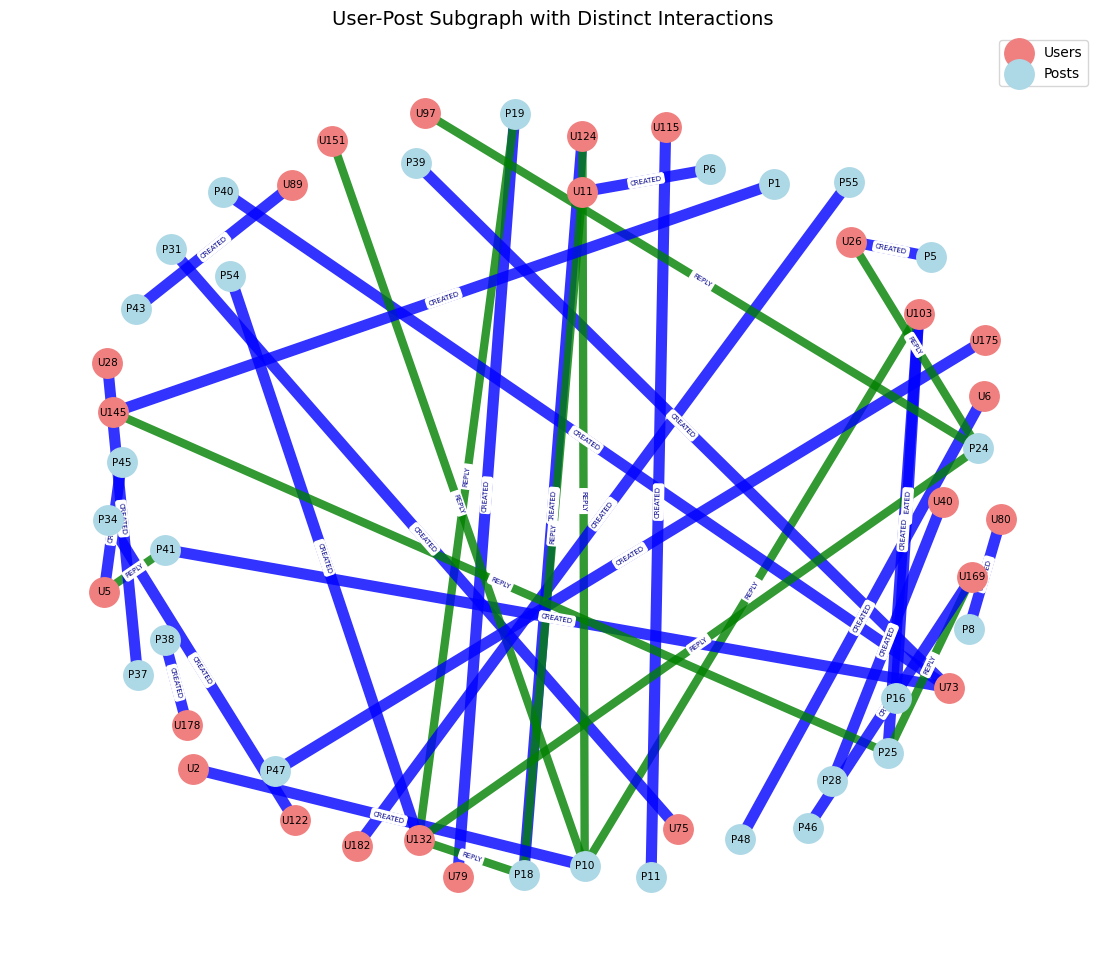

In [13]:
#Define short labels for nodes to improve readability in the visualization
interaction_labels = {
    'created': 'CREATED',  # Abbreviation for Created
    'replied': 'REPLY',    # Abbreviation for Replied
    'reposted': 'REPOST',  # Abbreviation for Reposted
    'quoted': 'QUOTED'     # Abbreviation for Quoted
}

# Extract a subgraph for visualization (e.g., first 50 nodes)
subgraph = B.subgraph(list(B.nodes)[:50])
short_labels = {node: node.replace("user_", "U").replace("post_", "P") for node in subgraph.nodes}

# Recalculate node positions for better readability
pos = nx.spring_layout(subgraph, seed=42, k=15)  # Add 'seed' for a stable layout

# Customize visualization with node sizes and colors
plt.figure(figsize=(14, 12))

# Separate user and post nodes for color distinction
user_nodes = [node for node in subgraph.nodes if node.startswith("user_")]
post_nodes = [node for node in subgraph.nodes if node.startswith("post_")]

# Draw user nodes in one color (e.g., light coral)
user_nodes_drawn = nx.draw_networkx_nodes(subgraph, pos, nodelist=user_nodes, node_color="lightcoral", 
                                          node_size=450, label="Users")

# Draw post nodes in another color (e.g., light blue)
post_nodes_drawn = nx.draw_networkx_nodes(subgraph, pos, nodelist=post_nodes, node_color="lightblue", 
                                          node_size=450, label="Posts")

# Customize edges with variable colors and widths
edge_colors = ["blue" if data["interaction"] == "created" else 
               "green" if data["interaction"] == "replied" else 
               "red" if data["interaction"] == "reposted" else "purple"
               for _, _, data in subgraph.edges(data=True)]

edge_widths = [8 if data["interaction"] == "created" else 
               6 if data["interaction"] == "replied" else 
               6 if data["interaction"] == "reposted" else 6
               for _, _, data in subgraph.edges(data=True)]

edges_drawn = nx.draw_networkx_edges(subgraph, pos, edge_color=edge_colors, width=edge_widths, alpha=0.8)

# Add interaction labels using abbreviations
edge_labels = {(u, v): interaction_labels[data['interaction']] for u, v, data in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=5, font_color="darkblue")

# Add labels to nodes
nx.draw_networkx_labels(subgraph, pos, labels=short_labels, font_size=7.5, font_color="black")

# Add a legend
plt.legend(
    [user_nodes_drawn, post_nodes_drawn],
    ["Users", "Posts"],
    loc="upper right",
    fontsize=10
)

# Add title and remove axes
plt.title("User-Post Subgraph with Distinct Interactions", fontsize=14)
plt.axis("off")

# Save the graph visualization as an image
plt.savefig("user_post_subgraph.png", format="png", dpi=300)

# Display the plot
plt.show()


In [14]:
# Extract nodes and their attributes
nodes_data = [
    {"node": n, **d} for n, d in B.nodes(data=True)
]
df_nodes = pd.DataFrame(nodes_data)

# Save nodes to a CSV file
df_nodes.to_csv("bipartite_nodes.csv", index=False)

# Extract edges and their attributes
edges_data = [
    {"source": u, "target": v, **d} for u, v, d in B.edges(data=True)
]
df_edges = pd.DataFrame(edges_data)

# Save edges to a CSV file
df_edges.to_csv("bipartite_edges.csv", index=False)

# Optional: Save the whole graph structure as an adjacency list
nx.write_adjlist(B, "bipartite_graph.adjlist")